In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA

Read in the data set "Miles_Traveled.csv" from the Data folder. Figure out how to set the date to a datetime index columns

In [4]:
df = pd.read_csv('D:/ML-Datasets/Udemy-TimeSeries/Miles_Traveled.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


In [5]:
df.columns = ['Value']

### Plot out the time series

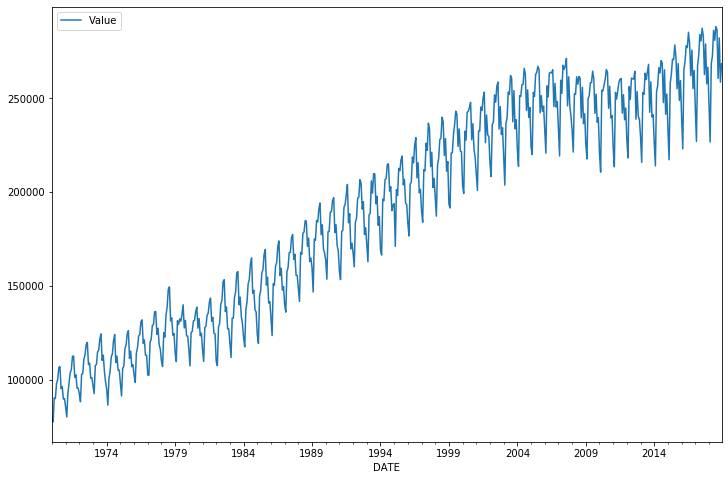

In [6]:
df.plot(figsize=(12,8))

### Perform a Seasonal Decomposition on the model and plot out the ETS components

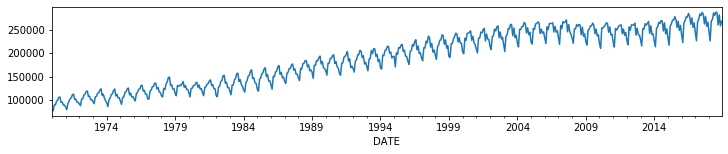

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Value'])
results.observed.plot(figsize=(12,2))

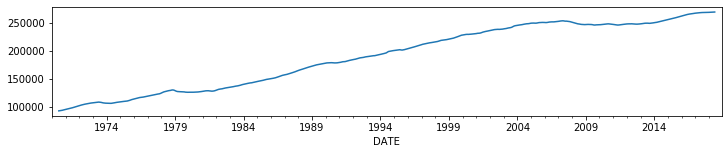

In [8]:
results.trend.plot(figsize=(12,2))

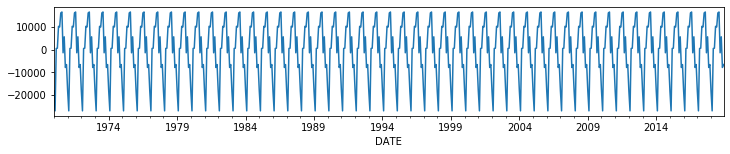

In [9]:
results.seasonal.plot(figsize=(12,2))

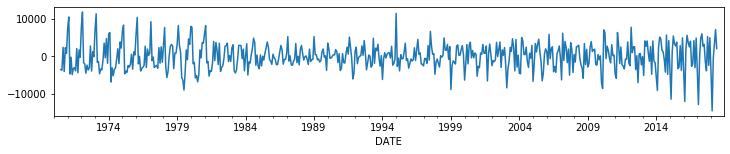

In [10]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [11]:
len(df)

588

In [12]:
train_len = len(df)-12

In [13]:
train = df.iloc[:train_len]
test = df.iloc[train_len:]
len(test)

12

## Scale Data

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 24
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

### Create the Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [17]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [18]:
# fit model
model.fit_generator(generator, epochs=30)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 552 steps
Epoch 1/30
552/552 [==============================] - 4s 7ms/step - loss: 0.0146
Epoch 2/30
552/552 [==============================] - 3s 6ms/step - loss: 0.0062
Epoch 3/30
552/552 [==============================] - 3s 5ms/step - loss: 0.0063
Epoch 4/30
552/552 [==============================] - 3s 5ms/step - loss: 0.0049
Epoch 5/30
552/552 [==============================] - 3s 5ms/step - loss: 0.0042
Epoch 6/30
552/552 [==============================] - 3s 5ms/step - loss: 0.0023
Epoch 7/30
552/552 [==============================] - 3s 5ms/step - loss: 0.0020
Epoch 8/30
552/552 [==============================] - 3s 5ms/step - loss: 0.0022
Epoch 9/30
552/552 [==============================] - 3s 5ms/step - loss: 0.0017
Epoch 10/30
552/552 [==============================] - 3s 5ms/step - loss: 0.0017
Epoch 11/30
552/552 [==============================] - 3s 5ms/step -

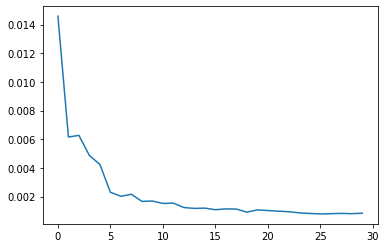

In [19]:
# Plot the Loss vs Epochs

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

In [21]:
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.79630397],
       [0.71226435],
       [0.90477416],
       [0.93121043],
       [0.98386382],
       [0.96757519],
       [1.        ],
       [0.9801859 ],
       [0.8824684 ],
       [0.95995255],
       [0.85883345],
       [0.90086755]])

In [22]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [23]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [24]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[241068.81405294],
       [227896.2039324 ],
       [255063.00141656],
       [260942.88116384],
       [270486.95437896],
       [272042.86914235],
       [278401.41009057],
       [274447.98560143],
       [262637.7939654 ],
       [268712.12083322],
       [254020.9915511 ],
       [256900.4028461 ]])

In [25]:
test['Predictions'] = true_predictions

C:\Miniconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
test

,Value,Predictions
DATE,,
2018-01-01,245695.0,241068.814053
2018-02-01,226660.0,227896.203932
2018-03-01,268480.0,255063.001417
2018-04-01,272475.0,260942.881164
2018-05-01,286164.0,270486.954379
2018-06-01,280877.0,272042.869142
2018-07-01,288145.0,278401.410091
2018-08-01,286608.0,274447.985601
2018-09-01,260595.0,262637.793965


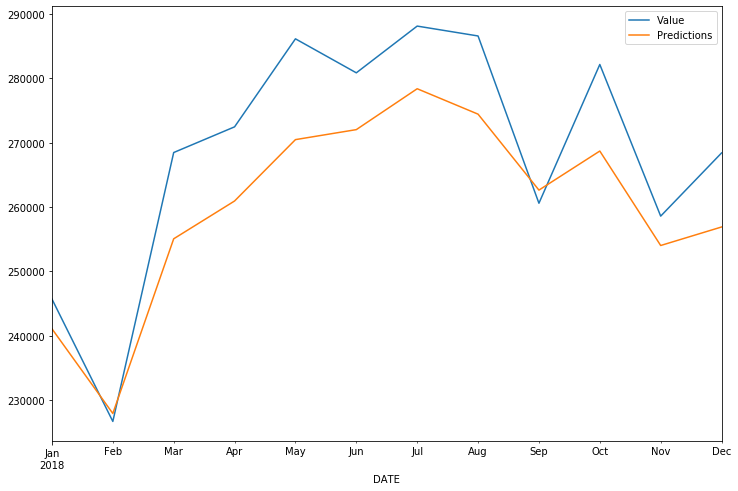

In [28]:
test.plot(figsize=(12,8), legend = True)